# Implémentation de GSA (version Notebook)



On se concentre sur deux exécutions :
1.  **Test des Travaux Pratiques** : $N=30$, $T_{\text{max}}=1000$, $G_0=100$, $\alpha=20$.
2.  **Tests Comparatifs** : Comme défini dans l'application, pour différentes valeurs de $G_0$ et $\alpha$.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore', 'divide by zero encountered in double_scalars')

## 1. Fonctions de base

In [9]:
# ========== FONCTIONS OBJECTIF ==========
def f1(x):
    """Fonction Sphère (Unimodale)"""
    return np.sum(x**2, axis=1)

def f8(x):
    """Fonction Schwefel (Multimodale)"""
    return -np.sum(x * np.sin(np.sqrt(np.abs(x))), axis=1)

In [10]:
# ========== IMPLEMENTATION GSA (version K-best, adaptée pour Notebook) ==========
def run_gsa(G0, alpha, func, N=100, D=30, LB=-500, UB=500, Tmax=300, epsilon=1e-15):
    t = 0
    x = np.random.uniform(LB, UB, (N, D))  # positions
    v = np.zeros((N, D))                   # vitesses
    bestvalues = []

    # Fitness initiale et meilleur global
    fitness = func(x)
    g_index = np.argmin(fitness)
    gbest = x[g_index].copy()
    bestvalues.append(fitness[g_index])

    print(f"Début GSA: func={func.__name__}, N={N}, Tmax={Tmax}, G0={G0}, alpha={alpha}")

    while t < Tmax:
        G = G0 * np.exp(-alpha * t / Tmax)

        # --- Calcul des masses ---
        worst = np.max(fitness)
        best = np.min(fitness)
        
        # Gestion de la division par zéro si toutes les fitness sont identiques
        if np.allclose(best, worst):
            mass = np.ones(N) / N
        else:
            m = (fitness - worst) / (best - worst + epsilon)
            mass_sum = np.sum(m)
            if np.allclose(mass_sum, 0):
                 mass = np.ones(N) / N # Ré-initialiser si la somme est nulle
            else:
                mass = m / (mass_sum + epsilon)
            mass = np.clip(mass, 0, None) # Assurer que les masses sont non-négatives

        # --- Détermination des K meilleurs agents ---
        K = max(1, int(np.ceil(N * (Tmax - t) / Tmax)))  # au moins 1
        Kbest_idx = np.argsort(fitness)[:K]

        # --- Calcul des forces et accélérations ---
        a = np.zeros((N, D))
        for i in range(N):
            F = np.zeros(D)
            for j in Kbest_idx:
                if j != i:
                    diff = x[j] - x[i]
                    dist = np.linalg.norm(diff) + epsilon
                    F += np.random.rand() * G * mass[j] * diff / dist
            a[i] = F

        # --- Mise à jour des vitesses et positions ---
        v = np.random.rand(N, D) * v + a
        x = np.clip(x + v, LB, UB)

        # --- Mise à jour de la fitness et du meilleur global ---
        fitness = func(x)
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < func(gbest[np.newaxis, :])[0]:
            gbest = x[current_best_idx].copy()

        bestvalues.append(func(gbest[np.newaxis, :])[0])
        t += 1
        
        # Affichage de la progression
        if (t % 100 == 0) or (t == Tmax):
            print(f"... Itération {t}/{Tmax}, Meilleure fitness: {bestvalues[-1]:.6f}")

    print(f"Fin GSA. Meilleur résultat: {bestvalues[-1]}")
    return bestvalues

## 2. Test spécifique "Travaux Pratiques"

Nous testons d'abord avec les paramètres exacts demandés dans le TP :
* $N = 30$
* $T_{\text{max}} = 1000$
* $G_0 = 100$
* $\alpha = 20$

In [11]:
# Paramètres du TP
params_tp = {
    'G0': 100.0,
    'alpha': 20.0,
    'N': 30,
    'D': 30,
    'Tmax': 1000,
    'LB': -500.0,
    'UB': 500.0
}

# Exécution pour f1
bestvalues_tp_f1 = run_gsa(func=f1, **params_tp)

# Exécution pour f8
bestvalues_tp_f8 = run_gsa(func=f8, **params_tp)

Début GSA: func=f1, N=30, Tmax=1000, G0=100.0, alpha=20.0
... Itération 100/1000, Meilleure fitness: 15080.319405
... Itération 200/1000, Meilleure fitness: 6609.334241
... Itération 300/1000, Meilleure fitness: 5574.606615
... Itération 400/1000, Meilleure fitness: 5412.832560
... Itération 500/1000, Meilleure fitness: 5389.021046
... Itération 600/1000, Meilleure fitness: 5385.818741
... Itération 700/1000, Meilleure fitness: 5385.548938
... Itération 800/1000, Meilleure fitness: 5385.515687
... Itération 900/1000, Meilleure fitness: 5385.512407
... Itération 1000/1000, Meilleure fitness: 5385.512191
Fin GSA. Meilleur résultat: 5385.51219050157
Début GSA: func=f8, N=30, Tmax=1000, G0=100.0, alpha=20.0
... Itération 100/1000, Meilleure fitness: -2767.095000
... Itération 200/1000, Meilleure fitness: -2767.095000
... Itération 300/1000, Meilleure fitness: -2767.095000
... Itération 400/1000, Meilleure fitness: -2767.095000
... Itération 500/1000, Meilleure fitness: -2767.095000
... Ité

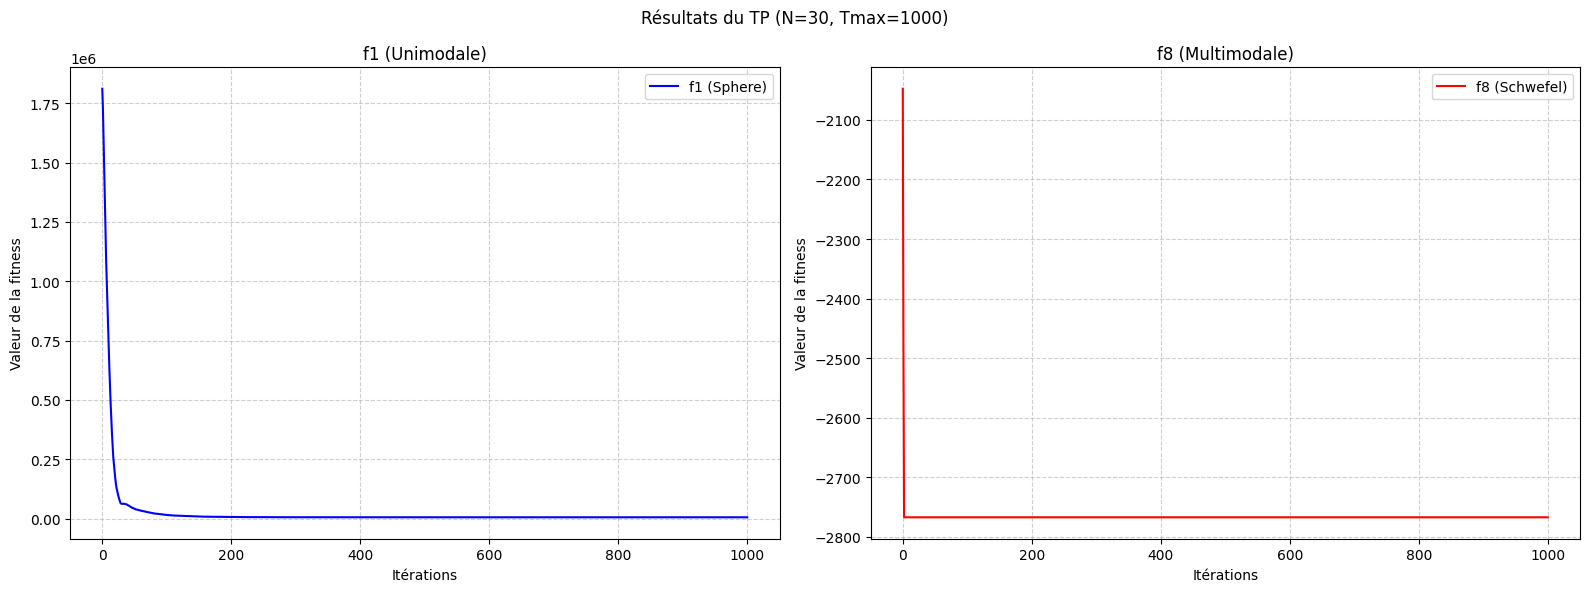

In [12]:
# Graphique des courbes de convergence pour le TP
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f"Résultats du TP (N={params_tp['N']}, Tmax={params_tp['Tmax']})")

# Courbe f1
ax1.plot(bestvalues_tp_f1, label="f1 (Sphere)", color='blue')
ax1.set_title("f1 (Unimodale)")
ax1.set_xlabel("Itérations")
ax1.set_ylabel("Valeur de la fitness")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Courbe f8
ax2.plot(bestvalues_tp_f8, label="f8 (Schwefel)", color='red')
ax2.set_title("f8 (Multimodale)")
ax2.set_xlabel("Itérations")
ax2.set_ylabel("Valeur de la fitness")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## 3. Tests Comparatifs (Mode Test)

Nous répliquons ici le "Mode Test" de l'application Streamlit. Nous allons fixer $N=100$ et $T_{\text{max}}=300$ (vos valeurs par défaut) et tester différentes combinaisons de $G_0$ et $\alpha$.

In [13]:
# ========== MULTI-TESTS POUR BENCHMARKS (adapté) ==========
def run_tests(tests, N, D, Tmax, LB, UB):
    results = []
    allcurves = {}
    funcs = [(f1, 'f1 Unimodal'), (f8, 'f8 Multimodal')]
    
    for G0, alpha in tests:
        for func, fname in funcs:
            bestvalues = run_gsa(G0, alpha, func, N=N, D=D, LB=LB, UB=UB, Tmax=Tmax)
            results.append({'Fonction': fname, 'G0': G0, 'alpha': alpha, 'Meilleur': bestvalues[-1]})
            allcurves.setdefault(fname, {})[f"G0={G0}, alpha={alpha}"] = bestvalues
    
    df = pd.DataFrame(results)
    return df, allcurves

# ========== GRAPHIQUES (adapté) ==========
def plot_comparisons(df, allcurves):
    print("\n--- Comparaison des meilleurs résultats finaux ---")
    
    # Création des graphiques à barres
    unique_funcs = df['Fonction'].unique()
    fig_bar, axes_bar = plt.subplots(1, len(unique_funcs), figsize=(12, 5))
    if len(unique_funcs) == 1:
        axes_bar = [axes_bar] # Rendre itérable s'il n'y a qu'un seul graphique
        
    fig_bar.suptitle('Meilleur résultat final par configuration')
    
    for ax, fname in zip(axes_bar, unique_funcs):
        subset = df[df['Fonction'] == fname].copy()
        subset['label'] = subset.apply(lambda row: f"G0={row['G0']}, α={row['alpha']}", axis=1)
        subset.set_index('label')['Meilleur'].plot(kind='bar', ax=ax, rot=45)
        ax.set_title(fname)
        ax.set_ylabel('Meilleure Fitness')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\n--- Courbes de convergence ---")
    for fname, curves in allcurves.items():
        fig, ax = plt.subplots(figsize=(10, 6))
        for label, curve in curves.items():
            ax.plot(curve, label=label)
        ax.set_xlabel("Itérations")
        ax.set_ylabel("Valeur de la fitness")
        ax.set_title(f"Courbes de convergence pour {fname}")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.show()

Lancement du mode test comparatif (N=100, Tmax=300)
Début GSA: func=f1, N=100, Tmax=300, G0=100, alpha=20
... Itération 100/300, Meilleure fitness: 100784.707607
... Itération 200/300, Meilleure fitness: 100301.363437
... Itération 300/300, Meilleure fitness: 100300.988275
Fin GSA. Meilleur résultat: 100300.98827549901
Début GSA: func=f8, N=100, Tmax=300, G0=100, alpha=20
... Itération 100/300, Meilleure fitness: -3546.489608
... Itération 200/300, Meilleure fitness: -3546.489608
... Itération 300/300, Meilleure fitness: -3546.489608
Fin GSA. Meilleur résultat: -3546.489607668364
Début GSA: func=f1, N=100, Tmax=300, G0=50, alpha=10
... Itération 100/300, Meilleure fitness: 166848.161141
... Itération 200/300, Meilleure fitness: 148684.681618
... Itération 300/300, Meilleure fitness: 148388.084288
Fin GSA. Meilleur résultat: 148388.08428832106
Début GSA: func=f8, N=100, Tmax=300, G0=50, alpha=10
... Itération 100/300, Meilleure fitness: -3086.009992
... Itération 200/300, Meilleure fitn

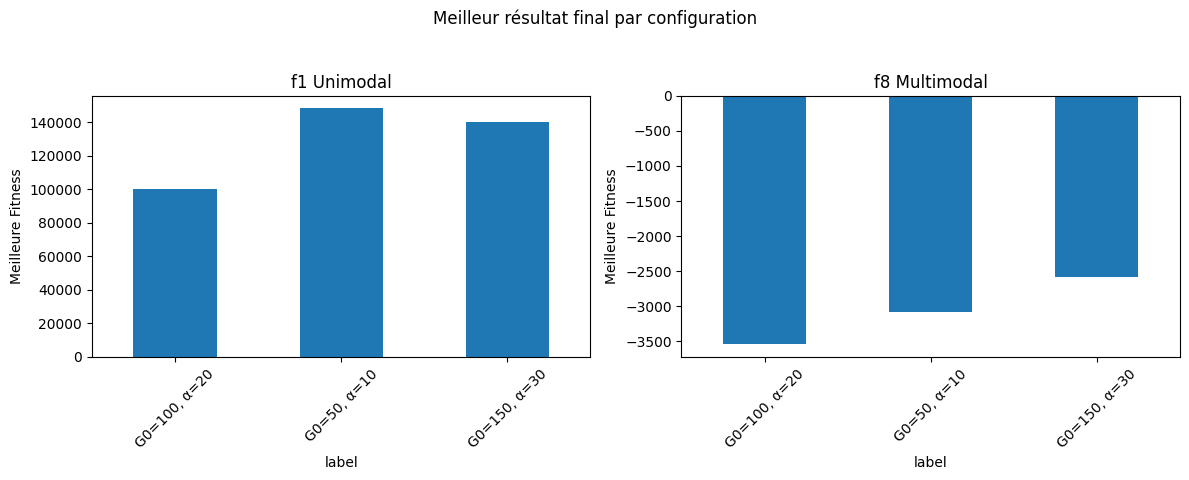


--- Courbes de convergence ---


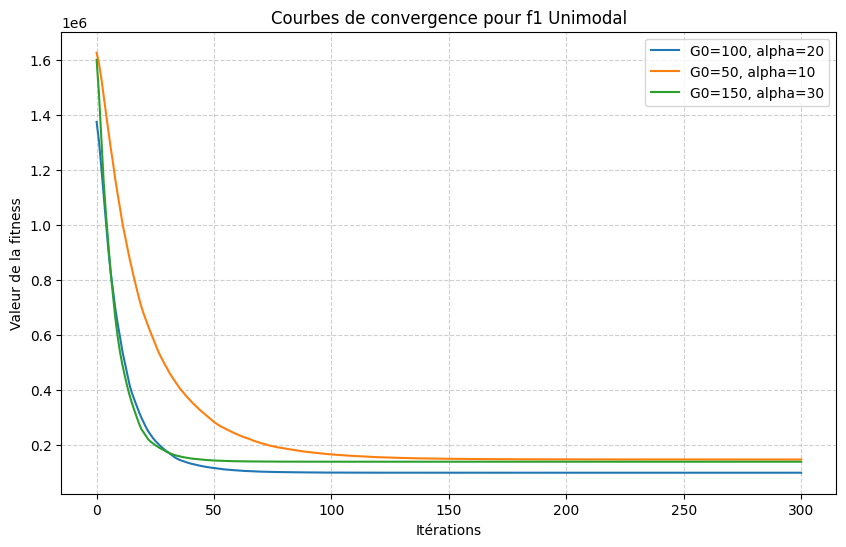

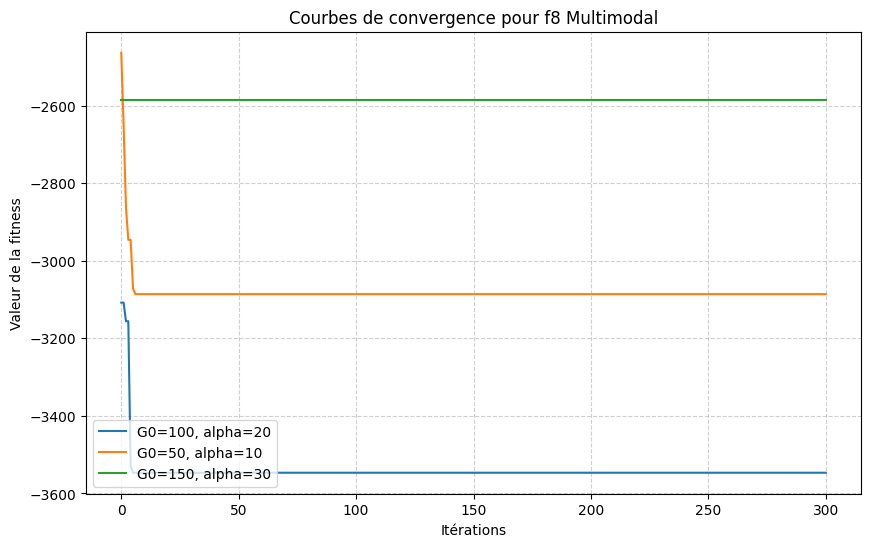

In [14]:
# Paramètres pour le mode test (basé sur vos valeurs par défaut)
params_test = {
    'N': 100,
    'D': 30,
    'Tmax': 300,
    'LB': -500.0,
    'UB': 500.0
}

# Liste des combinaisons (G0, alpha) à tester
tests_combinaisons = [(100, 20), (50, 10), (150, 30)]

print(f"Lancement du mode test comparatif (N={params_test['N']}, Tmax={params_test['Tmax']})")

df_results, allcurves_results = run_tests(tests_combinaisons, **params_test)

print("\n--- Tableau des résultats ---")
print(df_results.to_markdown(index=False))

# Affichage des graphiques comparatifs
plot_comparisons(df_results, allcurves_results)